In [1]:
#!pip install "notebook>=5.3" "ipywidgets>=7.5"
#!pip install chart_studio
#!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier, BaggingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, precision_recall_curve,f1_score
import seaborn as sn
import matplotlib.pyplot as plt
import warnings
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LassoCV
from sklearn.datasets import make_regression
import matplotlib
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report,confusion_matrix
import xgboost as xgb
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly.tools
import chart_studio.plotly as py
warnings.filterwarnings('ignore')

### Import the data

In [3]:
df = pd.read_csv("./data/DF_Daily_Classification.csv")

In [4]:
df

,name,artist,spotify_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,genre
0,Don't Start Now,Bristol Love,1jdOJBKLdLtSrV63ztyYdP,0.763,0.45900,0.363636,0.769460,0,0.0342,0.0931,0.005790,0.0741,0.2680,0.454581,0.055032,0.8,reggae
1,November Night,Joscho Stephan,4X2Tjj0MqatwWIZChec6NU,0.629,0.33300,0.181818,0.750574,1,0.0358,0.8740,0.863000,0.0878,0.5160,0.695579,0.057345,0.8,jazz
2,Bummerland,AJR,3QCMUnmMaqokrfNZes4D6S,0.629,0.83300,0.090909,0.853692,0,0.0855,0.1240,0.000000,0.1590,0.6530,0.368006,0.045169,0.8,rock
3,goosebumps,Travis Scott,2SzjMcZIsE2zUWQnccsTAo,0.847,0.71900,0.363636,0.936948,0,0.0468,0.0868,0.000000,0.1480,0.4420,0.591006,0.060530,0.8,hiphop
4,Super Jet,Tadd Dameron,0n9toZOivQbcwGuwNsPywM,0.501,0.64300,0.090909,0.820403,1,0.0473,0.7870,0.025100,0.1210,0.7570,0.580716,0.091404,0.8,jazz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13154,Lost in Pain,YunB,6m0dHm4wf7GW9lyVbpRy0r,0.757,0.28100,0.636364,0.890742,1,0.0500,0.8590,0.006310,0.1030,0.1430,0.590847,0.046739,0.8,hiphop
13155,Doh Back Back,Sparrow,43P9uBVBo2Vpc7XsmJNBhq,0.770,0.91700,0.636364,0.894587,1,0.0476,0.0563,0.000175,0.0341,0.9710,0.582402,0.096505,0.8,reggae
13156,Full Clip,Gang Starr,30oTS7bm0aH3p7lqjEIu8q,0.875,0.74500,0.090909,0.882180,1,0.2690,0.0227,0.000002,0.2870,0.7490,0.432696,0.053120,0.8,hiphop
13157,Silk,Alexei Orechin,0iYX1Xf1jihHuZOwW6YEJ1,0.355,0.31300,0.454545,0.742862,0,0.0362,0.4530,0.561000,0.0826,0.0746,0.565117,0.109972,0.8,jazz


#### Drop columns that are not relevant for the learning process and create a backup dataframe

In [5]:
good_data = df.drop(columns=["spotify_id","name","artist"])
backup_data = good_data.copy()

#### Split the data to train and test. The genre column will be our target

In [6]:
X_train,X_test,Y_train,Y_test = \
train_test_split(good_data.drop("genre",1),good_data["genre"])

## Data Exploration

We grouped the data by genre to get a better picture of how our data looks like

In [7]:
genre_counts = good_data.groupby('genre')['mode'].count()

In [8]:
genre_counts

genre
classical    3091
hiphop       2514
jazz         2984
reggae       1354
rock         3216
Name: mode, dtype: int64

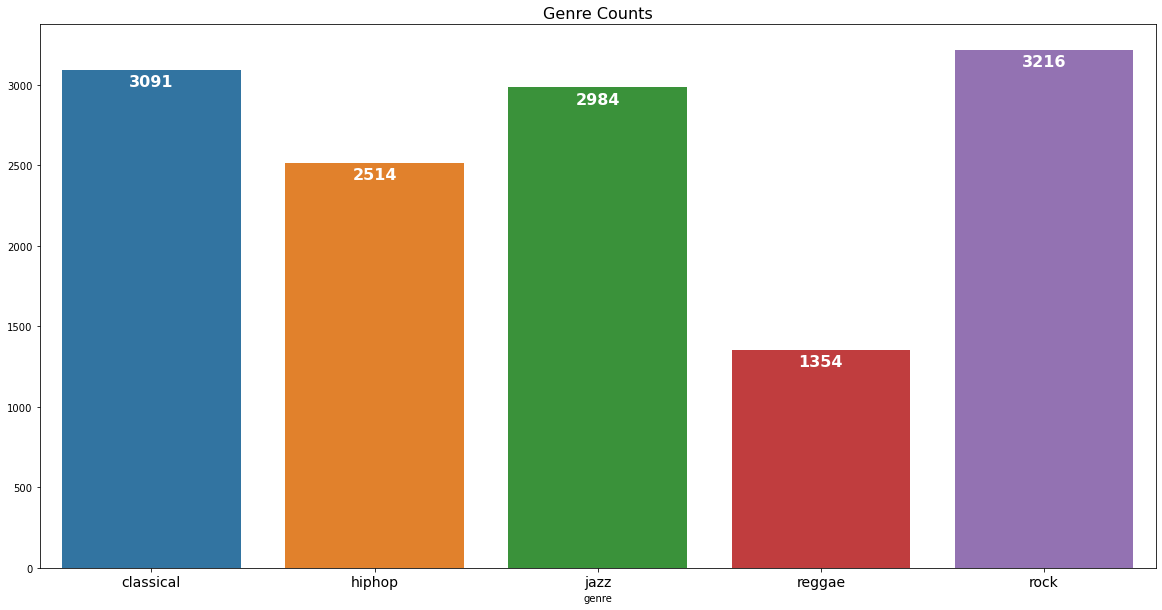

In [9]:
plt.figure(figsize=(20,10))
plt.title('Genre Counts', size=16)
plt.xticks(size=14)


g = sn.barplot(genre_counts.index, genre_counts.values);

for index, row in enumerate(genre_counts):
     g.text(index, row-100, row, color='white', ha="center", size='16', weight='bold')

plt.show()


# Classification with all features

In this task, we tested 5 different classification algorithms - KNN, Random Forest, Decision Tree, Naïve Bayes and XGBoost.

We wanted to find the optimal parameters for each algorithm in order to maximize our model performances. 
<br>
The end goal in to find the sweet spot of each algorithm and create a multivarient model.

## KNN

We changed the number of neighbors each iteration

In [11]:
for i in range(2,15):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, Y_train)
    print("The score for " + str(i) + " kNN is")
    print("Training: {}%".format(100*knn.score(X_train, Y_train)))
    print("Test set: {}%\n".format(100*knn.score(X_test, Y_test)))

The score for 2 kNN is
Training: 84.04093626507245%
Test set: 66.71732522796353%

The score for 3 kNN is
Training: 82.37916708886412%
Test set: 68.9969604863222%

The score for 4 kNN is
Training: 80.25129192420711%
Test set: 70.12158054711246%

The score for 5 kNN is
Training: 79.51160198601683%
Test set: 71.06382978723404%

The score for 6 kNN is
Training: 78.40713344817104%
Test set: 71.42857142857143%

The score for 7 kNN is
Training: 77.83970007092917%
Test set: 71.67173252279635%

The score for 8 kNN is
Training: 77.43439051575642%
Test set: 71.9452887537994%

The score for 9 kNN is
Training: 77.06961191610092%
Test set: 72.06686930091185%

The score for 10 kNN is
Training: 76.50217853885906%
Test set: 71.580547112462%

The score for 11 kNN is
Training: 76.4717803222211%
Test set: 71.51975683890578%

The score for 12 kNN is
Training: 76.1576654169622%
Test set: 71.580547112462%

The score for 13 kNN is
Training: 76.13739993920356%
Test set: 71.79331306990882%

The score for 14 kNN

### The best results were with k=9

## Random Forest

At first, we increased each iteration both the number of estimators and the depth of each tree. Our plan was to get a picture of how the algorithm reacts to the data, and then change each varible until we get the best results.

In [12]:
for i in range(1,5):
    forest = RandomForestClassifier(n_estimators=100*i, max_depth = 5*i)
    forest.fit(X_train, Y_train)
    print("The score for n_estimators = " + str(100*i) + " and max_depth = "+str(5*i) + " Random Forest is")
    print("Training: {}%".format(100*forest.score(X_train, Y_train)))
    print("Test set: {}%\n".format(100*forest.score(X_test, Y_test)))

The score for n_estimators = 100 and max_depth = 5 Random Forest is
Training: 73.78660451920153%
Test set: 72.52279635258358%

The score for n_estimators = 200 and max_depth = 10 Random Forest is
Training: 87.0402269733509%
Test set: 77.17325227963526%

The score for n_estimators = 300 and max_depth = 15 Random Forest is
Training: 98.9968588509474%
Test set: 78.54103343465046%

The score for n_estimators = 400 and max_depth = 20 Random Forest is
Training: 99.95946904448272%
Test set: 79.17933130699089%



### We noticed that at 300 trees and max depth of 15, the model is aleardy overfitted. We decided to go with 200 trees and increase the number of trees only.

In [13]:
for i in range(0,6):
    forest = RandomForestClassifier(n_estimators=(200 + 30*i), max_depth = 10)
    forest.fit(X_train, Y_train)
    print("The score for n_estimators = " + str(200 + 30*i) + " and max_depth = 10 Random Forest is")
    print("Training: {}%".format(100*forest.score(X_train, Y_train)))
    print("Test set: {}%\n".format(100*forest.score(X_test, Y_test)))

The score for n_estimators = 200 and max_depth = 10 Random Forest is
Training: 86.91863410679906%
Test set: 77.2644376899696%

The score for n_estimators = 230 and max_depth = 10 Random Forest is
Training: 86.87810315128179%
Test set: 77.11246200607903%

The score for n_estimators = 260 and max_depth = 10 Random Forest is
Training: 87.08075792886817%
Test set: 76.96048632218844%

The score for n_estimators = 290 and max_depth = 10 Random Forest is
Training: 87.03009423447158%
Test set: 77.08206686930092%

The score for n_estimators = 320 and max_depth = 10 Random Forest is
Training: 86.9895632789543%
Test set: 76.8693009118541%

The score for n_estimators = 350 and max_depth = 10 Random Forest is
Training: 87.08075792886817%
Test set: 76.99088145896657%



### Based on the results, we decided to go with 230 trees. Now we will test the optimal max depth of each tree in the forest.

In [15]:
for i in range(0,5):
    forest = RandomForestClassifier(n_estimators=230, max_depth = 10 + i)
    forest.fit(X_train, Y_train)
    print("The score for n_estimators = " + str(230) + " and max_depth = " +str(10 + i) + " Random Forest is")
    print("Training: {}%".format(100*forest.score(X_train, Y_train)))
    print("Test set: {}%\n".format(100*forest.score(X_test, Y_test)))

The score for n_estimators = 230 and max_depth = 10 Random Forest is
Training: 86.96929780119567%
Test set: 77.29483282674772%

The score for n_estimators = 230 and max_depth = 11 Random Forest is
Training: 90.31310163137096%
Test set: 77.56838905775076%

The score for n_estimators = 230 and max_depth = 12 Random Forest is
Training: 93.5758435505117%
Test set: 77.59878419452887%

The score for n_estimators = 230 and max_depth = 13 Random Forest is
Training: 95.99756814266897%
Test set: 78.32826747720365%

The score for n_estimators = 230 and max_depth = 14 Random Forest is
Training: 97.92278852973959%
Test set: 78.44984802431611%



### Based on the results, we decided to go with 10 as the max depth. We noticed that with max depth of 11, the model accuracy improve only by 0.3% but the train accuracy increases by 3.5% which might indicate on the model getting overfitted. 
### The best results were with the following parameters -  n_estimators = 230 and max_depth = 10 

## Decision Tree

We changed the max depth each iteration

In [16]:
for i in range(5,15):
    tree = DecisionTreeClassifier(max_depth=i,criterion="entropy")
    tree.fit(X_train, Y_train)
    print("Decision Tree")
    print("The score for max_depth = " +str(i) + " Decision Tree is")
    print("Training: {}%".format(100*tree.score(X_train, Y_train)))
    print("Test set: {}%\n".format(100*tree.score(X_test, Y_test)))

Decision Tree
The score for max_depth = 5 Decision Tree is
Training: 71.800587698855%
Test set: 71.15501519756839%

Decision Tree
The score for max_depth = 6 Decision Tree is
Training: 74.01965751342587%
Test set: 73.16109422492401%

Decision Tree
The score for max_depth = 7 Decision Tree is
Training: 75.33691356773737%
Test set: 72.37082066869301%

Decision Tree
The score for max_depth = 8 Decision Tree is
Training: 77.95116019860167%
Test set: 73.1306990881459%

Decision Tree
The score for max_depth = 9 Decision Tree is
Training: 81.01124734015605%
Test set: 72.97872340425532%

Decision Tree
The score for max_depth = 10 Decision Tree is
Training: 84.40571486472793%
Test set: 72.49240121580547%

Decision Tree
The score for max_depth = 11 Decision Tree is
Training: 87.95217347248962%
Test set: 70.85106382978724%

Decision Tree
The score for max_depth = 12 Decision Tree is
Training: 91.26557908602695%
Test set: 70.33434650455928%

Decision Tree
The score for max_depth = 13 Decision Tree

### The best results were with max depth of 8

## Naïve Bayes

In [17]:
nb = GaussianNB()
nb.fit(X_train, Y_train)
print("Naive Bayes")
print("Training: {}%".format(100*nb.score(X_train, Y_train)))
print("Test set: {}%\n".format(100*nb.score(X_test, Y_test)))

Naive Bayes
Training: 68.60877495186949%
Test set: 68.6018237082067%



## XGBoost

In this algorithm we wiil test different parameters to get the best results possible. Parameters that won't be changed:
<br>
num_class = 5 - The number of genres we have in our data.
<br>
objective='multi:softmax' - For multiclass classification.

### Creating the train and test sets

In [18]:
eval_set=[(X_train,Y_train),(X_test,Y_test)]

Starting point:
<br>
Max Depth = 5 - Maximum depth of a tree.
<br>
Learning rate= 0.1 - Step size shrinkage used in update to prevents overfitting. 
<br>
Gamma = 0 - Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.
<br>
We will increase the number of estimators.

In [19]:
for i in range(1,5):
    gbm = xgb.XGBClassifier( 
                            n_estimators=100*i,
                            max_depth=5,
                            objective='multi:softmax', 
                            num_class=5,
                            learning_rate=.1, 
                            gamma = 0
                           )
    fit_model = gbm.fit( 
                        X_train, Y_train, 
                        eval_set=eval_set,
                        eval_metric='mlogloss',
                        early_stopping_rounds=1000,
                        verbose=False
                       )
    test_accuracy = accuracy_score(Y_test, fit_model.predict(X_test, ntree_limit=gbm.best_ntree_limit))
    train_accuracy = accuracy_score(Y_train, fit_model.predict(X_train, ntree_limit=gbm.best_ntree_limit))
    print("The score for n_estimators = " + str(100*i) +" is: ")
    print("Training: {}%".format(100*train_accuracy))
    print("Test set: {}%\n".format(100*test_accuracy))

The score for n_estimators = 100 is: 
Training: 87.27327996757523%
Test set: 78.29787234042553%

The score for n_estimators = 200 is: 
Training: 91.7722160299929%
Test set: 78.57142857142857%

The score for n_estimators = 300 is: 
Training: 91.7722160299929%
Test set: 78.57142857142857%

The score for n_estimators = 400 is: 
Training: 91.7722160299929%
Test set: 78.57142857142857%



### With 100 estimators we got almost the same test set accuracy as in 400 estimators but we avoid overfitting. Therefore, we will choose 100 estimators.

### Now we will look for the best max depth with 100 estimators.

In [20]:
for i in range(0,5):
    gbm = xgb.XGBClassifier( 
                            n_estimators=100,
                            max_depth= 3 + i,
                            objective='multi:softmax', 
                            num_class=5,
                            learning_rate=.1, 
                            gamma = 0
                           )
    fit_model = gbm.fit( 
                        X_train, Y_train, 
                        eval_set=eval_set,
                        eval_metric='mlogloss',
                        early_stopping_rounds=1000,
                        verbose=False
                       )
    test_accuracy = accuracy_score(Y_test, fit_model.predict(X_test, ntree_limit=gbm.best_ntree_limit))
    train_accuracy = accuracy_score(Y_train, fit_model.predict(X_train, ntree_limit=gbm.best_ntree_limit))
    print("The score for max depth = " + str(3 + i) +" is: ")
    print("Training: {}%".format(100*train_accuracy))
    print("Test set: {}%\n".format(100*test_accuracy))

The score for max depth = 3 is: 
Training: 80.4640794406728%
Test set: 77.35562310030394%

The score for max depth = 4 is: 
Training: 83.82814874860675%
Test set: 77.72036474164133%

The score for max depth = 5 is: 
Training: 87.27327996757523%
Test set: 78.29787234042553%

The score for max depth = 6 is: 
Training: 91.32637551930287%
Test set: 78.48024316109422%

The score for max depth = 7 is: 
Training: 95.1160198601682%
Test set: 78.78419452887539%



### With max depth of 5 we avoided overfitting while getting high accuracy rate on our test set. Therefore, we will pick 5 as our max depth.

### Now we will look for the best learning rate with max depth of 5 and 100 estimators.

In [21]:
for i in [0.1,0.2,0.3,0.4,0.5]:
    gbm = xgb.XGBClassifier( 
                            n_estimators=100,
                            max_depth= 5,
                            objective='multi:softmax', 
                            num_class=5,
                            learning_rate= i, 
                            gamma = 0
                           )
    fit_model = gbm.fit( 
                        X_train, Y_train, 
                        eval_set=eval_set,
                        eval_metric='mlogloss',
                        early_stopping_rounds=1000,
                        verbose=False
                       )
    test_accuracy = accuracy_score(Y_test, fit_model.predict(X_test, ntree_limit=gbm.best_ntree_limit))
    train_accuracy = accuracy_score(Y_train, fit_model.predict(X_train, ntree_limit=gbm.best_ntree_limit))
    print("The score for learning rate = " + str(i) +" is: ")
    print("Training: {}%".format(100*train_accuracy))
    print("Test set: {}%\n".format(100*test_accuracy))

The score for learning rate = 0.1 is: 
Training: 87.27327996757523%
Test set: 78.29787234042553%

The score for learning rate = 0.2 is: 
Training: 91.95460532982065%
Test set: 78.69300911854104%

The score for learning rate = 0.3 is: 
Training: 92.0356672408552%
Test set: 78.90577507598783%

The score for learning rate = 0.4 is: 
Training: 89.6443408653359%
Test set: 77.87234042553192%

The score for learning rate = 0.5 is: 
Training: 90.19150876481913%
Test set: 78.08510638297872%



### The test result accuracy doesn't change that much while the model is getting slightly overfitted. Therefore, we will pick 0.1 as our learning rate.

### Now we will look for the best gamma for our parameters.

In [22]:
for i in [0, 0.1,0.2,0.3,0.4,0.5]:
    gbm = xgb.XGBClassifier( 
                            n_estimators=100,
                            max_depth= 5,
                            objective='multi:softmax', 
                            num_class=5,
                            learning_rate= 0.1, 
                            gamma = i
                           )
    fit_model = gbm.fit( 
                        X_train, Y_train, 
                        eval_set=eval_set,
                        eval_metric='mlogloss',
                        early_stopping_rounds=1000,
                        verbose=False
                       )
    test_accuracy = accuracy_score(Y_test, fit_model.predict(X_test, ntree_limit=gbm.best_ntree_limit))
    train_accuracy = accuracy_score(Y_train, fit_model.predict(X_train, ntree_limit=gbm.best_ntree_limit))
    print("The score for gamma = " + str(i) +" is: ")
    print("Training: {}%".format(100*train_accuracy))
    print("Test set: {}%\n".format(100*test_accuracy))

The score for gamma = 0 is: 
Training: 87.27327996757523%
Test set: 78.29787234042553%

The score for gamma = 0.1 is: 
Training: 87.34420913973047%
Test set: 78.2370820668693%

The score for gamma = 0.2 is: 
Training: 87.3036781842132%
Test set: 78.38905775075989%

The score for gamma = 0.3 is: 
Training: 87.32394366197182%
Test set: 78.17629179331307%

The score for gamma = 0.4 is: 
Training: 87.34420913973047%
Test set: 78.35866261398176%

The score for gamma = 0.5 is: 
Training: 87.42527105076502%
Test set: 78.35866261398176%



### The test result accuracy doesn't change as well as the training set accuracy. We so little improvement with gamma = 0.2 so we will take it.

In [23]:
gbm = xgb.XGBClassifier( 
                        n_estimators=100,
                        max_depth= 5,
                        objective='multi:softmax', 
                        num_class=5,
                        learning_rate= 0.1, 
                        gamma = 0.2
                       )
fit_model = gbm.fit( 
                    X_train, Y_train, 
                    eval_set=eval_set,
                    eval_metric='mlogloss',
                    early_stopping_rounds=1000,
                    verbose=False
                   )
test_accuracy = accuracy_score(Y_test, fit_model.predict(X_test, ntree_limit=gbm.best_ntree_limit))
train_accuracy = accuracy_score(Y_train, fit_model.predict(X_train, ntree_limit=gbm.best_ntree_limit))
print("Training: {}%".format(100*train_accuracy))
print("Test set: {}%\n".format(100*test_accuracy))

Training: 87.3036781842132%
Test set: 78.38905775075989%



### Our final parameters:

Number of estimators = 100
<br>
Max depth = 5
<br>
Learning rate = 0.1
<br>
Gamma = 0.2

### The final test results accuracy is over 78%

# Feature Selection For Better Performance

We used two methods in order to decide which features are the most influential and what features we can ignore in order to improve processing time and avoid overfitting.

### SelectKBest

In [24]:
data = backup_data.copy()
X = data.drop(columns=["genre"])  
y = data["genre"]    
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  
print(featureScores.nlargest(13,'Score')) 

               Specs        Score
7   instrumentalness  3335.251218
6       acousticness  3018.028977
1             energy  1440.689732
9            valence   860.695171
0       danceability   668.494057
5        speechiness   581.613331
3           loudness   324.963083
4               mode    67.547477
8           liveness    57.352316
10             tempo    36.892906
11       duration_ms    26.492570
12    time_signature    10.084608
2                key     7.472706


#### We can see that there are 7 features with a score higher than 300 and after that we noticed a huge drop in score. The 7 top features are - instrumentalness, acousticness, energy, valence, danceability, speechiness and loudness 

### Extra Trees Classifier

[0.15027269 0.117495   0.03780558 0.07771768 0.01444449 0.10442272
 0.14229985 0.11496837 0.04106399 0.08444655 0.04817371 0.05209141
 0.01479797]


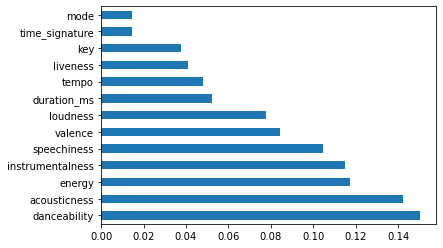

In [25]:
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(13).plot(kind='barh')
plt.show()

#### As we can see, this algorithm picked the same top 7 features as SelectKBest - instrumentalness, acousticness, energy, valence, danceability, speechiness and loudness 

### We wanted to see the distribution of each feature in each genre and try to see what features differentiate each genre.

In [26]:
df_classical = good_data.loc[good_data["genre"] == "classical"]
df_hiphop = good_data.loc[good_data["genre"] == "hiphop"]
df_jazz = good_data.loc[good_data["genre"] == "jazz"]
df_reggae = good_data.loc[good_data["genre"] == "reggae"]
df_rock= good_data.loc[good_data["genre"] == "rock"]
def get_dist_plot(feature):
    plt.figure(figsize=(15,10))
    sn.distplot(df_classical[feature], label='classical', hist=False, kde_kws={"shade": True})
    sn.distplot(df_hiphop[feature], label='hiphop', hist=False, kde_kws={"shade": True})
    sn.distplot(df_jazz[feature], label='jazz', hist=False, kde_kws={"shade": True})
    sn.distplot(df_reggae[feature], label='reggae', hist=False, kde_kws={"shade": True})
    sn.distplot(df_rock[feature], label='rock', hist=False, kde_kws={"shade": True})
    plt.legend(loc='upper right', fontsize=17)
    plt.title(feature.capitalize(), size=32)


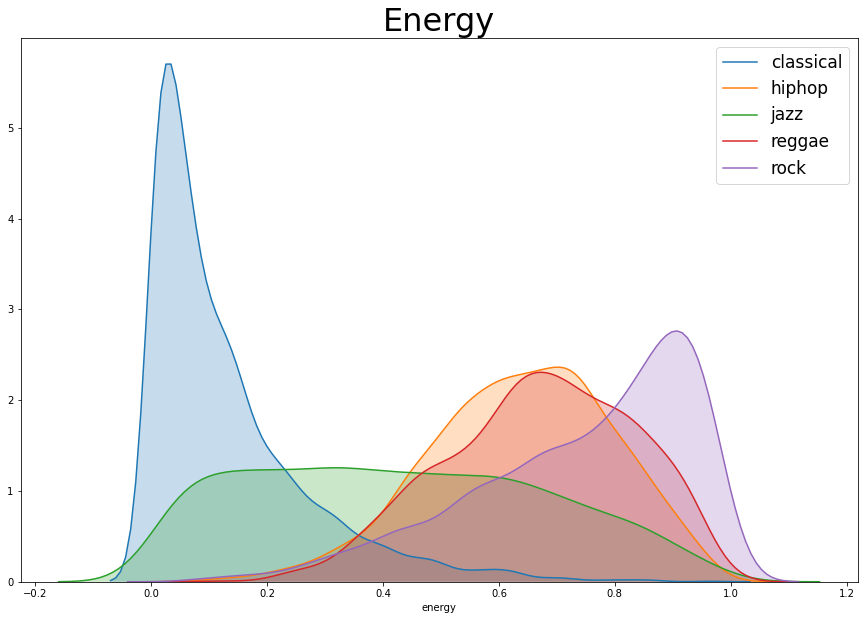

In [27]:
get_dist_plot('energy')

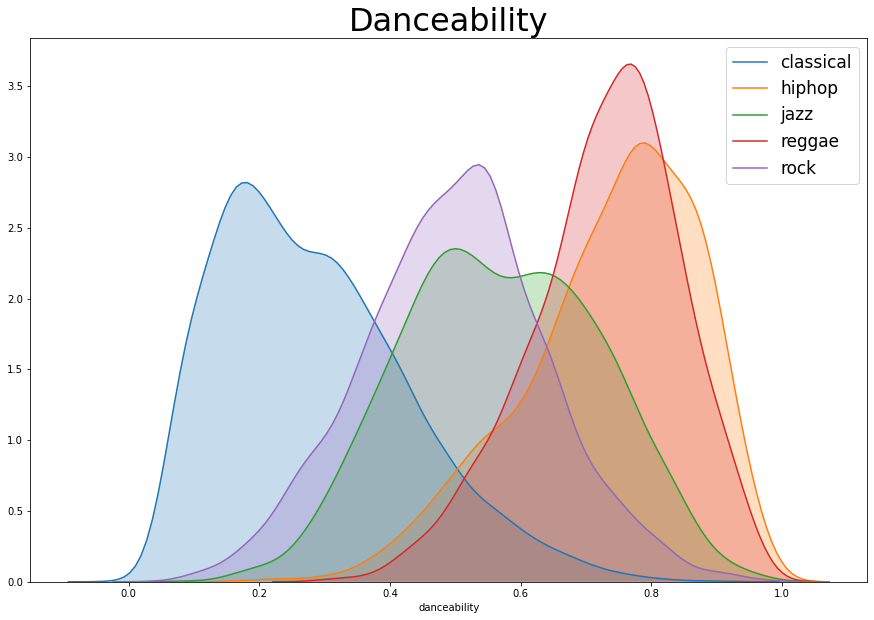

In [28]:
get_dist_plot('danceability')

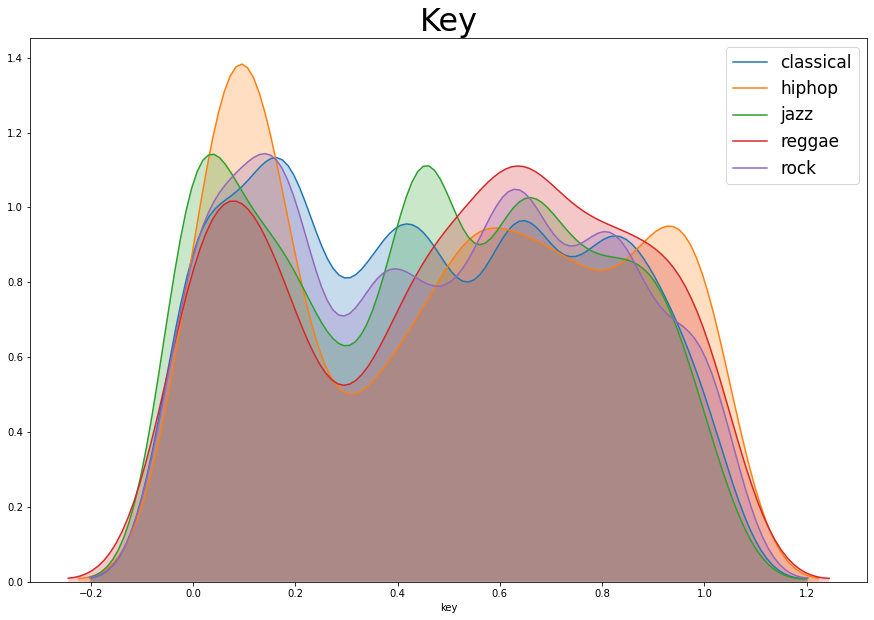

In [29]:
get_dist_plot('key')

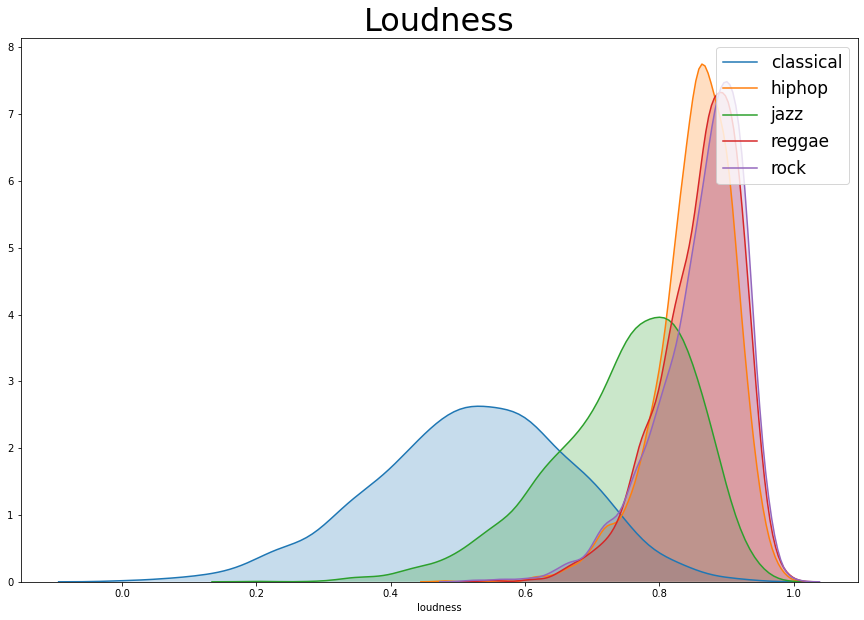

In [30]:
get_dist_plot('loudness')

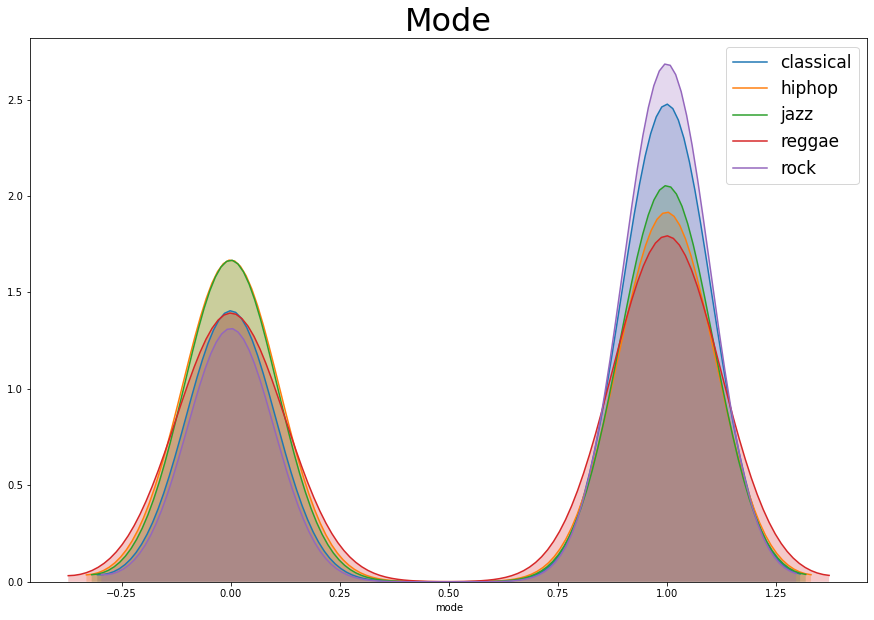

In [31]:
get_dist_plot('mode')

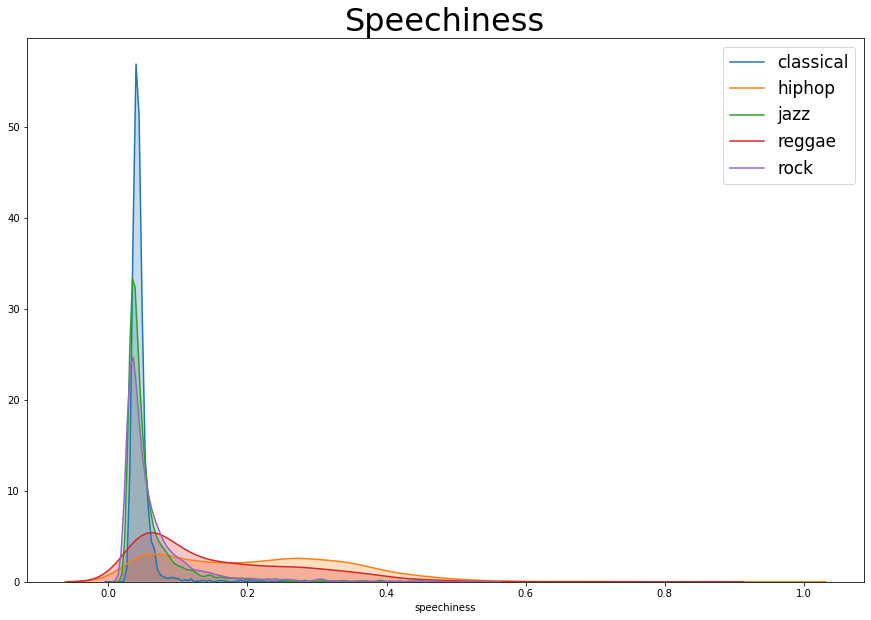

In [32]:
get_dist_plot('speechiness')

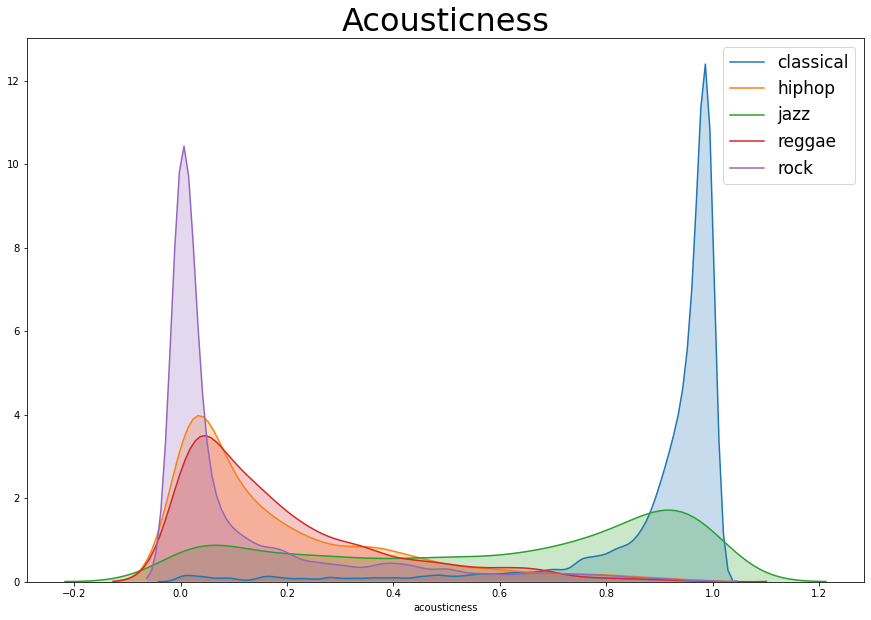

In [33]:
get_dist_plot('acousticness')

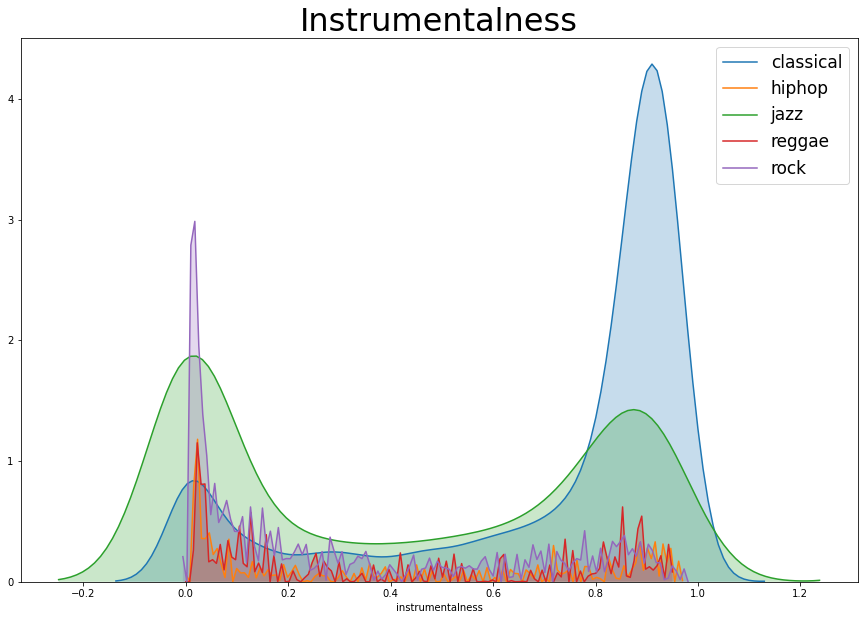

In [34]:
get_dist_plot('instrumentalness')

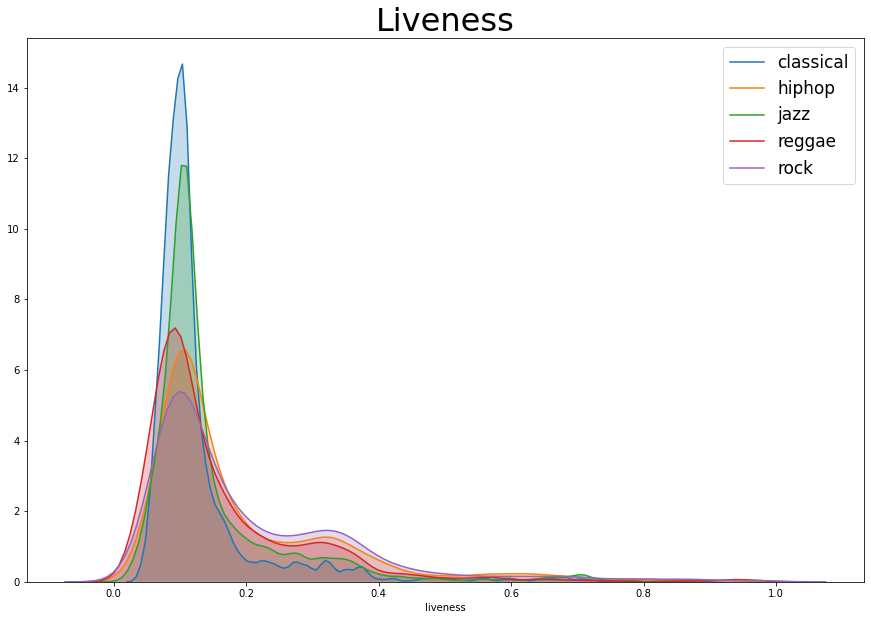

In [35]:
get_dist_plot('liveness')

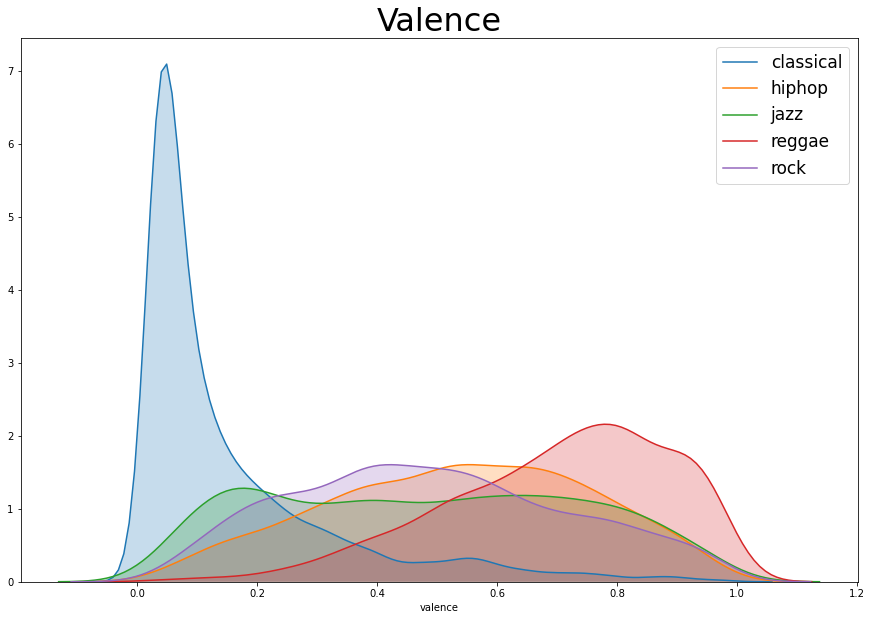

In [36]:
get_dist_plot('valence')

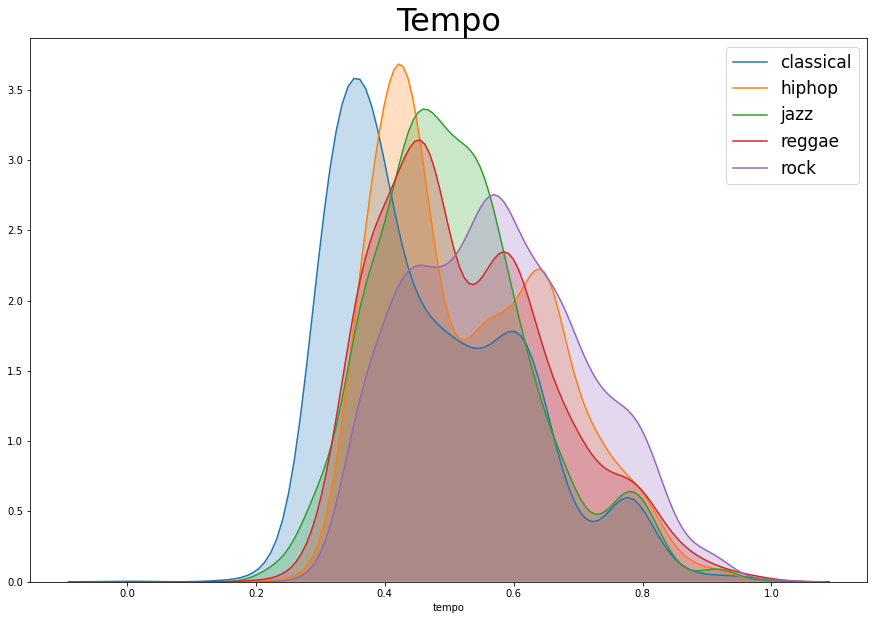

In [37]:
get_dist_plot('tempo')

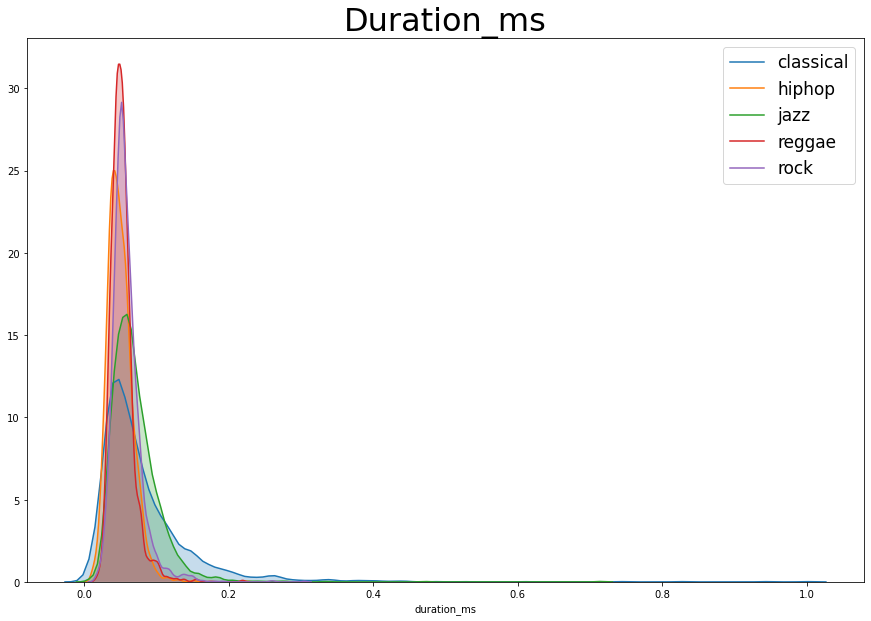

In [38]:
get_dist_plot('duration_ms')

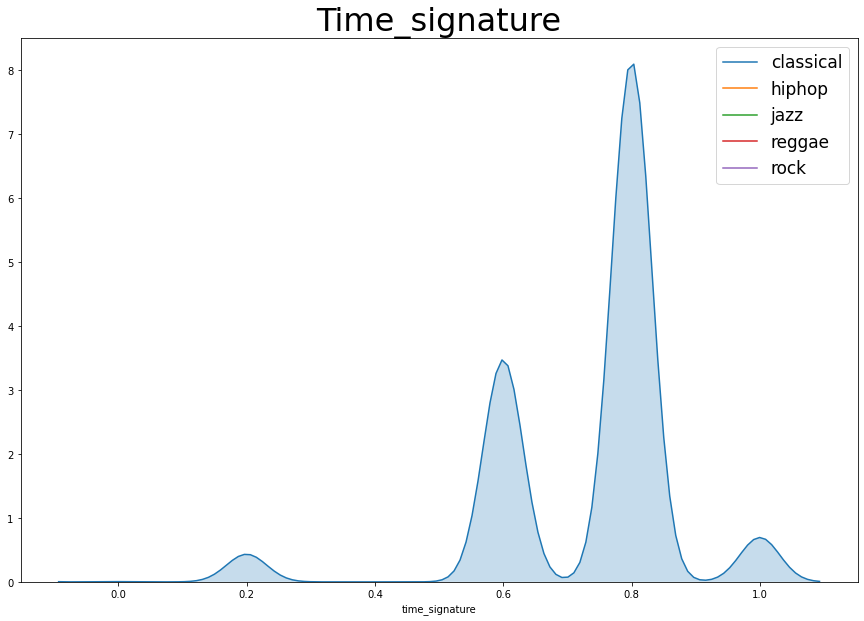

In [39]:
get_dist_plot('time_signature')

#### The graphs shows that with the top 7 features that both algorithms picked, we can see different distribution that will help our model to classify the data.

### We will remove the other 6 features that didn't make to our top 7 and split the data again to train and test sets. Later we will run all the algorithms once again to find the optinal parameters.

In [40]:
good_data.drop(columns=["mode","liveness","tempo","duration_ms","time_signature","key"], inplace=True)
X_train,X_test,Y_train,Y_test = \
train_test_split(good_data.drop("genre",1),good_data["genre"])

## KNN

In [41]:
for i in range(2,16):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, Y_train)
    print("The score for " + str(i) + " kNN is")
    print("Training: {}%".format(100*knn.score(X_train, Y_train)))
    print("Test set: {}%\n".format(100*knn.score(X_test, Y_test)))

The score for 2 kNN is
Training: 84.19292734826223%
Test set: 67.38601823708207%

The score for 3 kNN is
Training: 82.7439456885196%
Test set: 70.66869300911854%

The score for 4 kNN is
Training: 80.8288580403283%
Test set: 71.03343465045593%

The score for 5 kNN is
Training: 79.8257168912757%
Test set: 71.45896656534954%

The score for 6 kNN is
Training: 79.21775255851657%
Test set: 72.58358662613982%

The score for 7 kNN is
Training: 78.90363765325768%
Test set: 72.91793313069908%

The score for 8 kNN is
Training: 78.24500962610193%
Test set: 72.7355623100304%

The score for 9 kNN is
Training: 78.18421319282602%
Test set: 73.43465045592706%

The score for 10 kNN is
Training: 77.64717803222212%
Test set: 73.22188449848024%

The score for 11 kNN is
Training: 77.65731077110144%
Test set: 73.37386018237082%

The score for 12 kNN is
Training: 77.30266491032526%
Test set: 73.22188449848024%

The score for 13 kNN is
Training: 77.21147026041139%
Test set: 73.25227963525836%

The score for 14

### The best results were with k=11

## Random Forest

In [42]:
for i in range(0,6):
    forest = RandomForestClassifier(n_estimators=(200 + 30*i), max_depth = 10)
    forest.fit(X_train, Y_train)
    print("The score for n_estimators = " + str(200 + 30*i) + " and max_depth = 10 Random Forest is")
    print("Training: {}%".format(100*forest.score(X_train, Y_train)))
    print("Test set: {}%\n".format(100*forest.score(X_test, Y_test)))

The score for n_estimators = 200 and max_depth = 10 Random Forest is
Training: 85.65204174688418%
Test set: 75.80547112462006%

The score for n_estimators = 230 and max_depth = 10 Random Forest is
Training: 85.73310365791873%
Test set: 75.59270516717326%

The score for n_estimators = 260 and max_depth = 10 Random Forest is
Training: 85.59124531360827%
Test set: 75.92705167173253%

The score for n_estimators = 290 and max_depth = 10 Random Forest is
Training: 85.57097983584963%
Test set: 75.56231003039514%

The score for n_estimators = 320 and max_depth = 10 Random Forest is
Training: 85.61151079136691%
Test set: 75.5015197568389%

The score for n_estimators = 350 and max_depth = 10 Random Forest is
Training: 85.59124531360827%
Test set: 75.77507598784194%



### Based on the results, we decided to go with 260 trees. Now we will test the optimal max depth of each tree in the forest.

In [43]:
for i in range(0,5):
    forest = RandomForestClassifier(n_estimators=260, max_depth = 10 + i)
    forest.fit(X_train, Y_train)
    print("The score for n_estimators = " + str(260) + " and max_depth = " +str(10 + i) + " Random Forest is")
    print("Training: {}%".format(100*forest.score(X_train, Y_train)))
    print("Test set: {}%\n".format(100*forest.score(X_test, Y_test)))

The score for n_estimators = 260 and max_depth = 10 Random Forest is
Training: 85.60137805248759%
Test set: 75.6838905775076%

The score for n_estimators = 260 and max_depth = 11 Random Forest is
Training: 88.61080149964535%
Test set: 76.0790273556231%

The score for n_estimators = 260 and max_depth = 12 Random Forest is
Training: 91.75195055223428%
Test set: 75.77507598784194%

The score for n_estimators = 260 and max_depth = 13 Random Forest is
Training: 94.75124126051271%
Test set: 76.23100303951368%

The score for n_estimators = 260 and max_depth = 14 Random Forest is
Training: 96.8081872530145%
Test set: 76.0790273556231%



### Based on the results, we decided to go with 11 as the max depth. 
### The best results were with the following parameters -  n_estimators = 260 and max_depth = 11 


## Decision Tree

In [44]:
for i in range(5,15):
    tree = DecisionTreeClassifier(max_depth=i,criterion="entropy")
    tree.fit(X_train, Y_train)
    print("Decision Tree")
    print("The score for max_depth = " +str(i) + " Decision Tree is")
    print("Training: {}%".format(100*tree.score(X_train, Y_train)))
    print("Test set: {}%\n".format(100*tree.score(X_test, Y_test)))

Decision Tree
The score for max_depth = 5 Decision Tree is
Training: 71.73979126557909%
Test set: 70.69908814589667%

Decision Tree
The score for max_depth = 6 Decision Tree is
Training: 74.15138311885703%
Test set: 72.1580547112462%

Decision Tree
The score for max_depth = 7 Decision Tree is
Training: 75.70169216739285%
Test set: 71.70212765957447%

Decision Tree
The score for max_depth = 8 Decision Tree is
Training: 77.56611612118756%
Test set: 71.48936170212767%

Decision Tree
The score for max_depth = 9 Decision Tree is
Training: 80.23102644644847%
Test set: 71.21580547112461%

Decision Tree
The score for max_depth = 10 Decision Tree is
Training: 83.22018441584761%
Test set: 70.45592705167174%

Decision Tree
The score for max_depth = 11 Decision Tree is
Training: 86.38159894619515%
Test set: 70.0%

Decision Tree
The score for max_depth = 12 Decision Tree is
Training: 89.89765933731888%
Test set: 68.81458966565349%

Decision Tree
The score for max_depth = 13 Decision Tree is
Trainin

### The best results were with max depth of 6

## Naïve Bayes

In [45]:
nb = GaussianNB()
nb.fit(X_train, Y_train)
print("Naive Bayes")
print("Training: {}%".format(100*nb.score(X_train, Y_train)))
print("Test set: {}%\n".format(100*nb.score(X_test, Y_test)))

Naive Bayes
Training: 69.44979227885297%
Test set: 67.59878419452887%



## XGBoost

We found out that the most influencial parameters are number of estimators and max depth. Therefore we will use the other optimal parameters that we found earlier and test different values for number of estimators and max depth.
Parameters that won't be changed:
<br>
num_class = 5 
<br>
objective='multi:softmax' 
<br>
learning_rate = 0.1 
<br>
gamma=0.2

### Creating the train and test sets

In [46]:
eval_set=[(X_train,Y_train),(X_test,Y_test)]

#### We will increase the number of estimators.

In [47]:
for i in range(1,5):
    gbm = xgb.XGBClassifier( 
                            n_estimators=100*i,
                            max_depth=5,
                            objective='multi:softmax', 
                            num_class=5,
                            learning_rate=.1, 
                            gamma = 0.2
                           )
    fit_model = gbm.fit( 
                        X_train, Y_train, 
                        eval_set=eval_set,
                        eval_metric='mlogloss',
                        early_stopping_rounds=1000,
                        verbose=False
                       )
    test_accuracy = accuracy_score(Y_test, fit_model.predict(X_test, ntree_limit=gbm.best_ntree_limit))
    train_accuracy = accuracy_score(Y_train, fit_model.predict(X_train, ntree_limit=gbm.best_ntree_limit))
    print("The score for n_estimators = " + str(100*i) +" is: ")
    print("Training: {}%".format(100*train_accuracy))
    print("Test set: {}%\n".format(100*test_accuracy))

The score for n_estimators = 100 is: 
Training: 83.28098084912352%
Test set: 76.0790273556231%

The score for n_estimators = 200 is: 
Training: 84.07133448171041%
Test set: 76.10942249240121%

The score for n_estimators = 300 is: 
Training: 84.07133448171041%
Test set: 76.10942249240121%

The score for n_estimators = 400 is: 
Training: 84.07133448171041%
Test set: 76.10942249240121%



### With 200 estimators we got the same test set accuracy as in 400 estimators but with less execution time. Therefore, we will choose 200 estimators.
### Now we will look for the best max depth with 200 estimators.


In [48]:
for i in range(0,5):
    gbm = xgb.XGBClassifier( 
                            n_estimators=200,
                            max_depth= 3 + i,
                            objective='multi:softmax', 
                            num_class=5,
                            learning_rate=.1, 
                            gamma = 0.2
                           )
    fit_model = gbm.fit( 
                        X_train, Y_train, 
                        eval_set=eval_set,
                        eval_metric='mlogloss',
                        early_stopping_rounds=1000,
                        verbose=False
                       )
    test_accuracy = accuracy_score(Y_test, fit_model.predict(X_test, ntree_limit=gbm.best_ntree_limit))
    train_accuracy = accuracy_score(Y_train, fit_model.predict(X_train, ntree_limit=gbm.best_ntree_limit))
    print("The score for max depth = " + str(3 + i) +" is: ")
    print("Training: {}%".format(100*train_accuracy))
    print("Test set: {}%\n".format(100*test_accuracy))

The score for max depth = 3 is: 
Training: 80.57553956834532%
Test set: 75.5015197568389%

The score for max depth = 4 is: 
Training: 82.6324855608471%
Test set: 75.77507598784194%

The score for max depth = 5 is: 
Training: 84.07133448171041%
Test set: 76.10942249240121%

The score for max depth = 6 is: 
Training: 87.00982875671293%
Test set: 76.29179331306992%

The score for max depth = 7 is: 
Training: 88.90465092714561%
Test set: 75.6838905775076%



### With max depth of 5 where we avoided overfitting while getting almost the same accuracy rate as higher max depth values.

### Our final parameters:
Number of estimators = 200
<br>
Max depth = 5
<br>
Learning rate = 0.1
<br>
Gamma = 0.2

### The final test results accuracy is over 76%

## The reduction of features helped some algorithms performances while not affecting significantly bad on the others. As we said before, reduction of features helps execution time and avoidence of overfitting so we will work with the top 7 features we selected earlier.

# Reduction of dimensions with PCA 

### Before making final concultions, we wanted to test reduction of dimensions with PCA and see how it affects our model

In [49]:
good_data = backup_data.copy()

In [50]:
good_data.drop(columns=["mode","liveness","tempo","duration_ms","time_signature","key"], inplace=True)

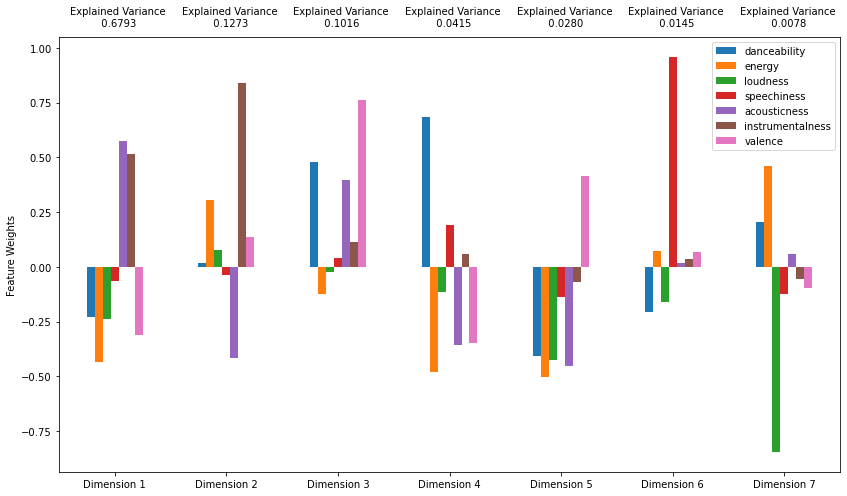

In [51]:
from sklearn.decomposition import PCA
import visuals as vs
pca_DF = good_data.drop(columns=["genre"], inplace=False)
pca = PCA(n_components=7).fit(pca_DF)
pca_results = vs.pca_results(pca_DF,pca)

### With 3 dimentions we get 90% of the data.

In [52]:
pca = PCA(n_components=3).fit(pca_DF)
reduced_data = pca.transform(pca_DF)
reduced_data = pd.DataFrame(reduced_data,columns=['Dimension 1','Dimension 2','Dimension 3'])
reduced_data["genre"] = df["genre"]
X_train,X_test,Y_train,Y_test = \
train_test_split(reduced_data.drop("genre",1),good_data["genre"])

## KNN

In [53]:
for i in range(2,15):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, Y_train)
    print("The score for " + str(i) + " kNN is")
    print("Training: {}%".format(100*knn.score(X_train, Y_train)))
    print("Test set: {}%\n".format(100*knn.score(X_test, Y_test)))

The score for 2 kNN is
Training: 81.87253014489816%
Test set: 61.15501519756839%

The score for 3 kNN is
Training: 79.69399128584456%
Test set: 64.4984802431611%

The score for 4 kNN is
Training: 77.6370452933428%
Test set: 65.6838905775076%

The score for 5 kNN is
Training: 76.50217853885906%
Test set: 66.01823708206686%

The score for 6 kNN is
Training: 75.52943560644442%
Test set: 66.93009118541033%

The score for 7 kNN is
Training: 74.70868375721957%
Test set: 66.56534954407294%

The score for 8 kNN is
Training: 74.25271050765022%
Test set: 67.68996960486322%

The score for 9 kNN is
Training: 73.83726821359814%
Test set: 67.20364741641338%

The score for 10 kNN is
Training: 73.90819738575337%
Test set: 67.62917933130699%

The score for 11 kNN is
Training: 73.62448069713243%
Test set: 67.2644376899696%

The score for 12 kNN is
Training: 73.24956935859763%
Test set: 67.35562310030396%

The score for 13 kNN is
Training: 72.95571993109738%
Test set: 67.23404255319149%

The score for 14

### The best results were with k=8 

## Random Forest

In [54]:
for i in range(0,6):
    forest = RandomForestClassifier(n_estimators=(200 + 30*i), max_depth = 10)
    forest.fit(X_train, Y_train)
    print("The score for n_estimators = " + str(200 + 30*i) + " and max_depth = 10 Random Forest is")
    print("Training: {}%".format(100*forest.score(X_train, Y_train)))
    print("Test set: {}%\n".format(100*forest.score(X_test, Y_test)))

The score for n_estimators = 200 and max_depth = 10 Random Forest is
Training: 76.83655892187659%
Test set: 66.80851063829788%

The score for n_estimators = 230 and max_depth = 10 Random Forest is
Training: 77.01894822170433%
Test set: 66.96048632218844%

The score for n_estimators = 260 and max_depth = 10 Random Forest is
Training: 77.07974465498025%
Test set: 67.14285714285714%

The score for n_estimators = 290 and max_depth = 10 Random Forest is
Training: 77.06961191610092%
Test set: 67.20364741641338%

The score for n_estimators = 320 and max_depth = 10 Random Forest is
Training: 77.24186847704935%
Test set: 66.93009118541033%

The score for n_estimators = 350 and max_depth = 10 Random Forest is
Training: 77.02908096058366%
Test set: 67.23404255319149%



### Based on the results, we decided to go with 290 trees. Now we will test the optimal max depth of each tree in the forest.

In [55]:
for i in range(0,5):
    forest = RandomForestClassifier(n_estimators=290, max_depth = 10 + i)
    forest.fit(X_train, Y_train)
    print("The score for n_estimators = " + str(290) + " and max_depth = " +str(10 + i) + " Random Forest is")
    print("Training: {}%".format(100*forest.score(X_train, Y_train)))
    print("Test set: {}%\n".format(100*forest.score(X_test, Y_test)))


The score for n_estimators = 290 and max_depth = 10 Random Forest is
Training: 77.00881548282501%
Test set: 66.93009118541033%

The score for n_estimators = 290 and max_depth = 11 Random Forest is
Training: 80.84912351808694%
Test set: 66.99088145896657%

The score for n_estimators = 290 and max_depth = 12 Random Forest is
Training: 85.22646671395279%
Test set: 67.17325227963525%

The score for n_estimators = 290 and max_depth = 13 Random Forest is
Training: 89.4822170432668%
Test set: 67.72036474164133%

The score for n_estimators = 290 and max_depth = 14 Random Forest is
Training: 92.81588813456277%
Test set: 67.93313069908815%



### Based on the results, we decided to go with 11 as the max depth. We noticed that with max depth of 12 the model accuracy improve only by 0.18% but the train accuracy increases by 4% which might indicate on the model getting overfitted. 
### The best results were with the following parameters -  n_estimators = 290 and max_depth = 11 


## Decision Tree

In [56]:
for i in range(5,15):
    tree = DecisionTreeClassifier(max_depth=i,criterion="entropy")
    tree.fit(X_train, Y_train)
    print("Decision Tree")
    print("The score for max_depth = " +str(i) + " Decision Tree is")
    print("Training: {}%".format(100*tree.score(X_train, Y_train)))
    print("Test set: {}%\n".format(100*tree.score(X_test, Y_test)))

Decision Tree
The score for max_depth = 5 Decision Tree is
Training: 65.163643732901%
Test set: 62.857142857142854%

Decision Tree
The score for max_depth = 6 Decision Tree is
Training: 66.72408552031615%
Test set: 63.28267477203647%

Decision Tree
The score for max_depth = 7 Decision Tree is
Training: 68.9330225960077%
Test set: 64.22492401215806%

Decision Tree
The score for max_depth = 8 Decision Tree is
Training: 70.50359712230215%
Test set: 64.68085106382979%

Decision Tree
The score for max_depth = 9 Decision Tree is
Training: 73.23943661971832%
Test set: 64.55927051671733%

Decision Tree
The score for max_depth = 10 Decision Tree is
Training: 76.16779815584152%
Test set: 63.79939209726444%

Decision Tree
The score for max_depth = 11 Decision Tree is
Training: 79.12655790860269%
Test set: 63.55623100303951%

Decision Tree
The score for max_depth = 12 Decision Tree is
Training: 82.38929982774343%
Test set: 63.495440729483285%

Decision Tree
The score for max_depth = 13 Decision Tr

### The best results were with max depth of 8

## Naïve Bayes

In [57]:
nb = GaussianNB()
nb.fit(X_train, Y_train)
print("Naive Bayes")
print("Training: {}%".format(100*nb.score(X_train, Y_train)))
print("Test set: {}%\n".format(100*nb.score(X_test, Y_test)))

Naive Bayes
Training: 62.45820245212281%
Test set: 62.036474164133736%



## XGBoost

We found out that the most influencial parameters are number of estimators and max depth. Therefore we will use the other optimal parameters that we found earlier and test different values for number of estimators and max depth.
Parameters that won't be changed:
<br>
num_class = 5 
<br>
objective='multi:softmax' 
<br>
learning_rate = 0.1 
<br>
gamma=0.2

### Creating the train and test sets

In [58]:
eval_set=[(X_train,Y_train),(X_test,Y_test)]

We will increase the number of estimators.

In [59]:
for i in range(1,5):
    gbm = xgb.XGBClassifier( 
                            n_estimators=100*i,
                            max_depth=5,
                            objective='multi:softmax', 
                            num_class=5,
                            learning_rate=.1, 
                            gamma = 0
                           )
    fit_model = gbm.fit( 
                        X_train, Y_train, 
                        eval_set=eval_set,
                        eval_metric='mlogloss',
                        early_stopping_rounds=1000,
                        verbose=False
                       )
    test_accuracy = accuracy_score(Y_test, fit_model.predict(X_test, ntree_limit=gbm.best_ntree_limit))
    train_accuracy = accuracy_score(Y_train, fit_model.predict(X_train, ntree_limit=gbm.best_ntree_limit))
    print("The score for n_estimators = " + str(100*i) +" is: ")
    print("Training: {}%".format(100*train_accuracy))
    print("Test set: {}%\n".format(100*test_accuracy))

The score for n_estimators = 100 is: 
Training: 74.05005573006383%
Test set: 68.05471124620061%

The score for n_estimators = 200 is: 
Training: 78.60978822575743%
Test set: 67.75075987841946%

The score for n_estimators = 300 is: 
Training: 78.93403586989564%
Test set: 67.93313069908815%

The score for n_estimators = 400 is: 
Training: 78.93403586989564%
Test set: 67.93313069908815%



### With 100 estimators we got the best results
### Now we will look for the best max depth with 100 estimators.

In [60]:
for i in range(0,5):
    gbm = xgb.XGBClassifier( 
                            n_estimators=100,
                            max_depth= 3 + i,
                            objective='multi:softmax', 
                            num_class=5,
                            learning_rate=.1, 
                            gamma = 0
                           )
    fit_model = gbm.fit( 
                        X_train, Y_train, 
                        eval_set=eval_set,
                        eval_metric='mlogloss',
                        early_stopping_rounds=1000,
                        verbose=False
                       )
    test_accuracy = accuracy_score(Y_test, fit_model.predict(X_test, ntree_limit=gbm.best_ntree_limit))
    train_accuracy = accuracy_score(Y_train, fit_model.predict(X_train, ntree_limit=gbm.best_ntree_limit))
    print("The score for max depth = " + str(3 + i) +" is: ")
    print("Training: {}%".format(100*train_accuracy))
    print("Test set: {}%\n".format(100*test_accuracy))

The score for max depth = 3 is: 
Training: 68.40612017428312%
Test set: 66.62613981762918%

The score for max depth = 4 is: 
Training: 70.92917215523356%
Test set: 67.14285714285714%

The score for max depth = 5 is: 
Training: 74.05005573006383%
Test set: 68.05471124620061%

The score for max depth = 6 is: 
Training: 76.86695713851454%
Test set: 67.62917933130699%

The score for max depth = 7 is: 
Training: 80.58567230722464%
Test set: 67.59878419452887%




### With max depth of 5 we got the best results. Therefore, we will pick 5 as our max depth.


### Our final parameters:
Number of estimators = 100
<br>
Max depth = 5
<br>
Learning rate = 0.1
<br>
Gamma = 0.2

### The final test results accuracy is over 68%

## The reduction of dimentions decreased the performance of all algorithms, therefore, we decided to avoid it.

# Finals results with the optimal parameters and top features

### How to measure songs performances:
F1 = (TP) / (TP + 0.5(FP+FN))
<br>
Precision - (TP) / (TP + FP)
<br>
Recall - (TP) / (TP + FN)
<br>
Accuracy - (TP + TN) / (TP + FP + TN + FN)
<br>
FPR - (FP) / (FP + TN)
<br>
TRP - (TP) / (TP + FN)
<br>
ROC curve - Plotted with TPR against the FPR where TPR is on the y-axis and FPR is on the x-axis.
<br>
AUC - Represents the degree or measure of separability. Higher the AUC, the better the model is at predicting 0s as 0s and 1s as 1s. This the area under the ROC curve.

In [61]:
good_data = backup_data.copy()
good_data.drop(columns=["mode","liveness","tempo","duration_ms","time_signature","key"], inplace=True)
X_train,X_test,Y_train,Y_test = \
train_test_split(good_data.drop("genre",1),good_data["genre"])
labels = ['classical','hiphop','jazz','reggae','rock']
accuracy_dict = dict()

In [62]:
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    #cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm = pd.DataFrame(cm_perc, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.show(sn.heatmap(cm, annot=annot, fmt='', ax=ax))

def printCM(Y_test, predictions,labels):
    cm = confusion_matrix(Y_test, predictions)
    for i in range(len(labels)):
        print ('TP cases for {0} music is {1}' ''.format(labels[i] , cm[i][i]))
    print ('------------'*3)
    for j in range(len(labels)):   
        for i in range(len(labels)):
            if j != i:
                   print('FP - Predicated {0} instead of {1}: {2} times'''.format(labels[j], labels[i], cm[i][j]))
    print ('------------'*3)
    for i in range(len(labels)):   
        for j in range(len(labels)):
            if j != i:
                   print('FN - Predicated {1} instead of {0}: {2} times'''.format(labels[i], labels[j], cm[i][j]))

def print_Stats(classifier,X_train, Y_train,X_test, Y_test,name, labels, predictions,dictionary):
    print(name)
    train_rate = round((100*classifier.score(X_train, Y_train)),2)
    test_rate = round((100*classifier.score(X_test, Y_test)),2)
    print("Training Set Success Rate: {}%".format(train_rate))
    print("Test Set Success Rate - Accuracy: {}%\n".format(test_rate))
    p = precision_score(Y_test, predictions, average=None, labels=labels)
    r = recall_score(Y_test, predictions, average=None, labels=labels)
    f1 = f1_score(Y_test, predictions, average=None, labels=labels)
    accuracy = accuracy_score(Y_test, predictions)
    dictionary[name] = round((100*accuracy),2)
    metricsdf = pd.DataFrame([p,r,f1], index= ['precision','recall','f1'], columns=labels)
    print("\n")
    print(metricsdf)
    print("\n")

    nb_y_predict = predictions
    nb_y_expected =  Y_test


    # Binarize the output - for th e ROC
    bz_nb_y_expected = label_binarize(nb_y_expected, classes=labels)
    bz_nb_y_predict = label_binarize(nb_y_predict, classes=labels)
    n_classes = bz_nb_y_expected.shape[1]

    # Compute ROC curve and ROC area for each class
    nb_fpr = dict()
    nb_tpr = dict()
    nb_roc_auc = dict()
    for i in range(n_classes):
        nb_fpr[i], nb_tpr[i], _ = roc_curve(bz_nb_y_expected[:, i], bz_nb_y_predict[:, i])
        nb_roc_auc[i] = auc(nb_fpr[i], nb_tpr[i])

    # Compute micro-average ROC curve and ROC area
    nb_fpr["micro"],nb_tpr["micro"], _ = roc_curve(bz_nb_y_expected.ravel(), bz_nb_y_predict.ravel())
    nb_roc_auc["micro"] = auc(nb_fpr["micro"],  nb_tpr["micro"])

    #plotting the statistics data
    plt.figure()
    lw =1.5
    plt.plot(nb_fpr[2], nb_tpr[2], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' %  nb_roc_auc["micro"])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic of Decision Tree')
    plt.legend(loc="lower right")
    plt.show()
    cm_analysis(Y_test, predictions,labels)
    print('')
    

## KNN

KNN
Training Set Success Rate: 77.61%
Test Set Success Rate - Accuracy: 74.07%



           classical    hiphop      jazz    reggae      rock
precision   0.909695  0.664244  0.667984  0.502165  0.782305
recall      0.865992  0.745514  0.701245  0.342183  0.815534
f1          0.887306  0.702537  0.684211  0.407018  0.798574




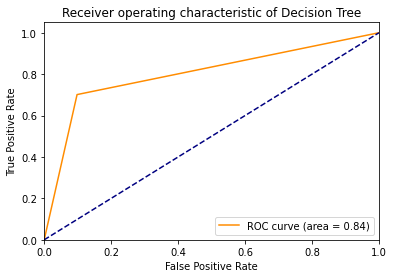

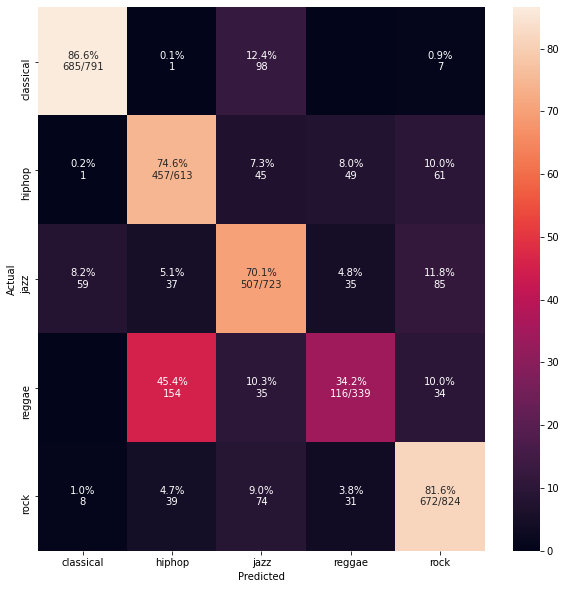

In [73]:
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train, Y_train)
predictions = knn.predict(X_test)
print_Stats(knn,X_train, Y_train,X_test, Y_test,"KNN", labels,predictions,accuracy_dict)

In [74]:
printCM(Y_test, predictions,labels)

TP cases for classical music is 685
TP cases for hiphop music is 457
TP cases for jazz music is 507
TP cases for reggae music is 116
TP cases for rock music is 672
------------------------------------
FP - Predicated classical instead of hiphop: 1 times
FP - Predicated classical instead of jazz: 59 times
FP - Predicated classical instead of reggae: 0 times
FP - Predicated classical instead of rock: 8 times
FP - Predicated hiphop instead of classical: 1 times
FP - Predicated hiphop instead of jazz: 37 times
FP - Predicated hiphop instead of reggae: 154 times
FP - Predicated hiphop instead of rock: 39 times
FP - Predicated jazz instead of classical: 98 times
FP - Predicated jazz instead of hiphop: 45 times
FP - Predicated jazz instead of reggae: 35 times
FP - Predicated jazz instead of rock: 74 times
FP - Predicated reggae instead of classical: 0 times
FP - Predicated reggae instead of hiphop: 49 times
FP - Predicated reggae instead of jazz: 35 times
FP - Predicated reggae instead of roc

## Random Forest

Random Forest
Training Set Success Rate: 88.05%
Test Set Success Rate - Accuracy: 76.81%



           classical    hiphop      jazz    reggae      rock
precision   0.911842  0.695839  0.688860  0.582524  0.816785
recall      0.876106  0.791191  0.744122  0.353982  0.838592
f1          0.893617  0.740458  0.715426  0.440367  0.827545




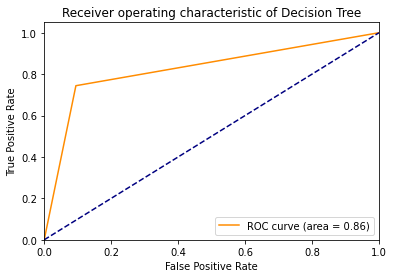

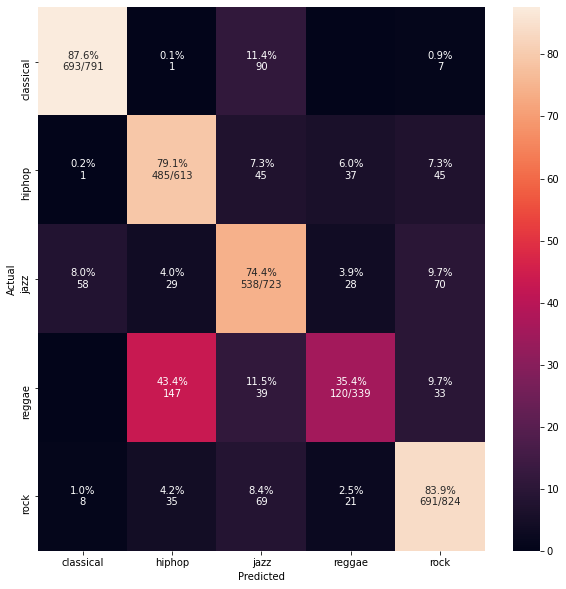

In [75]:
forest = RandomForestClassifier(n_estimators=260, max_depth = 11)
forest.fit(X_train, Y_train)
predictions = forest.predict(X_test)
print_Stats(forest,X_train, Y_train,X_test, Y_test,"Random Forest", labels,predictions,accuracy_dict)

In [76]:
printCM(Y_test, predictions,labels)

TP cases for classical music is 693
TP cases for hiphop music is 485
TP cases for jazz music is 538
TP cases for reggae music is 120
TP cases for rock music is 691
------------------------------------
FP - Predicated classical instead of hiphop: 1 times
FP - Predicated classical instead of jazz: 58 times
FP - Predicated classical instead of reggae: 0 times
FP - Predicated classical instead of rock: 8 times
FP - Predicated hiphop instead of classical: 1 times
FP - Predicated hiphop instead of jazz: 29 times
FP - Predicated hiphop instead of reggae: 147 times
FP - Predicated hiphop instead of rock: 35 times
FP - Predicated jazz instead of classical: 90 times
FP - Predicated jazz instead of hiphop: 45 times
FP - Predicated jazz instead of reggae: 39 times
FP - Predicated jazz instead of rock: 69 times
FP - Predicated reggae instead of classical: 0 times
FP - Predicated reggae instead of hiphop: 37 times
FP - Predicated reggae instead of jazz: 28 times
FP - Predicated reggae instead of roc

## Decision Tree

Decision Tree
Training Set Success Rate: 73.86%
Test Set Success Rate - Accuracy: 72.37%



           classical    hiphop      jazz    reggae      rock
precision   0.906780  0.673813  0.621495  0.458937  0.775982
recall      0.811631  0.717781  0.735823  0.280236  0.815534
f1          0.856571  0.695103  0.673844  0.347985  0.795266




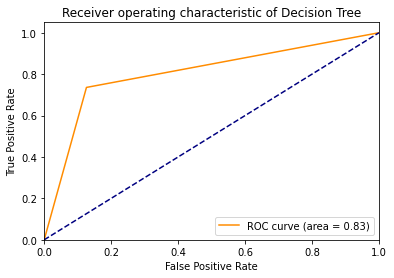

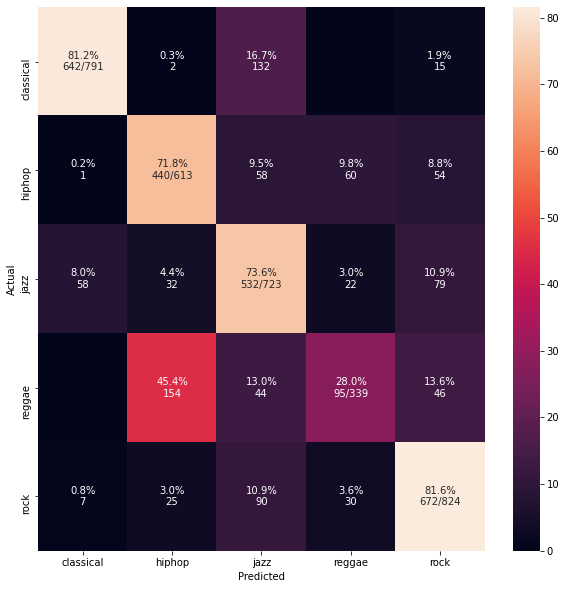

In [77]:
tree = DecisionTreeClassifier(max_depth=6,criterion="entropy")
tree.fit(X_train, Y_train)
predictions = tree.predict(X_test)
print_Stats(tree,X_train, Y_train,X_test, Y_test,"Decision Tree", labels,predictions,accuracy_dict)

In [78]:
printCM(Y_test, predictions,labels)

TP cases for classical music is 642
TP cases for hiphop music is 440
TP cases for jazz music is 532
TP cases for reggae music is 95
TP cases for rock music is 672
------------------------------------
FP - Predicated classical instead of hiphop: 1 times
FP - Predicated classical instead of jazz: 58 times
FP - Predicated classical instead of reggae: 0 times
FP - Predicated classical instead of rock: 7 times
FP - Predicated hiphop instead of classical: 2 times
FP - Predicated hiphop instead of jazz: 32 times
FP - Predicated hiphop instead of reggae: 154 times
FP - Predicated hiphop instead of rock: 25 times
FP - Predicated jazz instead of classical: 132 times
FP - Predicated jazz instead of hiphop: 58 times
FP - Predicated jazz instead of reggae: 44 times
FP - Predicated jazz instead of rock: 90 times
FP - Predicated reggae instead of classical: 0 times
FP - Predicated reggae instead of hiphop: 60 times
FP - Predicated reggae instead of jazz: 22 times
FP - Predicated reggae instead of roc

## Naïve Bayes

Naive Bayes
Training Set Success Rate: 68.58%
Test Set Success Rate - Accuracy: 70.09%



           classical    hiphop      jazz    reggae      rock
precision   0.799097  0.689076  0.623622  0.442724  0.762632
recall      0.895070  0.668842  0.547718  0.421829  0.787621
f1          0.844365  0.678808  0.583211  0.432024  0.774925




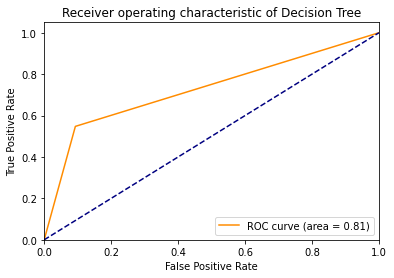

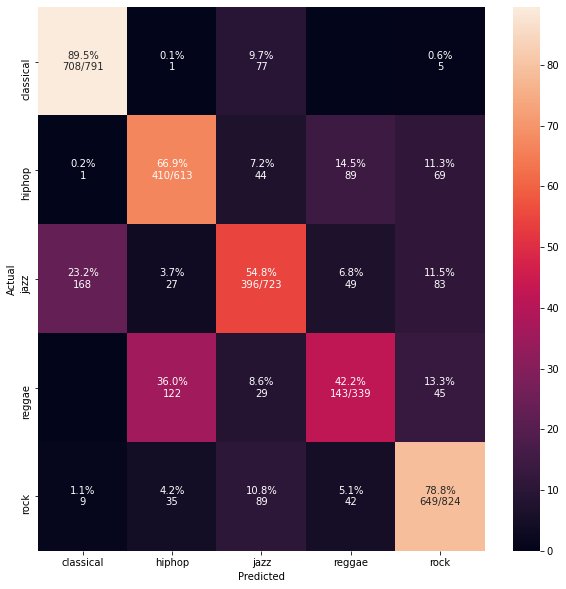

In [79]:
nb = GaussianNB()
nb.fit(X_train, Y_train)
predictions = nb.predict(X_test)
print_Stats(nb,X_train, Y_train,X_test, Y_test,"Naive Bayes", labels,predictions,accuracy_dict)

In [80]:
printCM(Y_test, predictions,labels)

TP cases for classical music is 708
TP cases for hiphop music is 410
TP cases for jazz music is 396
TP cases for reggae music is 143
TP cases for rock music is 649
------------------------------------
FP - Predicated classical instead of hiphop: 1 times
FP - Predicated classical instead of jazz: 168 times
FP - Predicated classical instead of reggae: 0 times
FP - Predicated classical instead of rock: 9 times
FP - Predicated hiphop instead of classical: 1 times
FP - Predicated hiphop instead of jazz: 27 times
FP - Predicated hiphop instead of reggae: 122 times
FP - Predicated hiphop instead of rock: 35 times
FP - Predicated jazz instead of classical: 77 times
FP - Predicated jazz instead of hiphop: 44 times
FP - Predicated jazz instead of reggae: 29 times
FP - Predicated jazz instead of rock: 89 times
FP - Predicated reggae instead of classical: 0 times
FP - Predicated reggae instead of hiphop: 89 times
FP - Predicated reggae instead of jazz: 49 times
FP - Predicated reggae instead of ro

## XGBoost

XGBoost
Training Set Success Rate: 68.58%
Test Set Success Rate - Accuracy: 70.09%



           classical    hiphop      jazz    reggae      rock
precision   0.900645  0.684515  0.693904  0.542601  0.826506
recall      0.882427  0.771615  0.739972  0.356932  0.832524
f1          0.891443  0.725460  0.716198  0.430605  0.829504




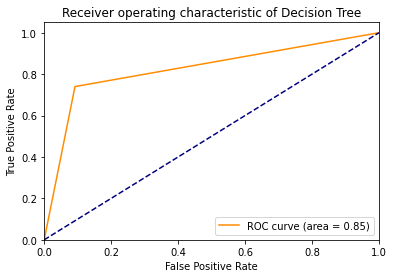

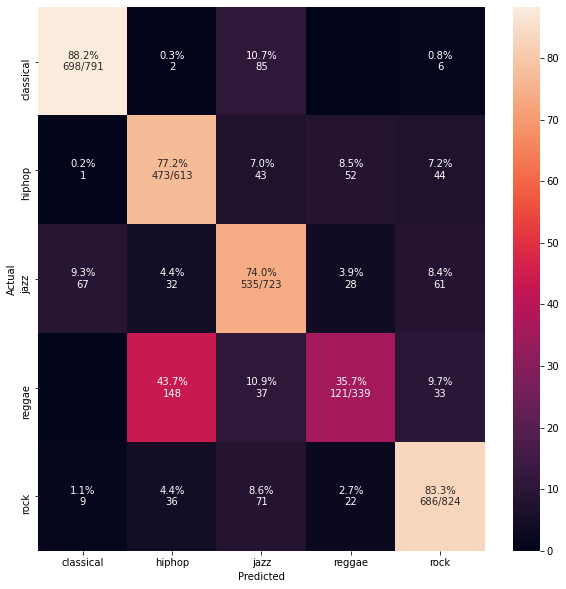

In [81]:
gbm = xgb.XGBClassifier( 
                        n_estimators=200,
                        max_depth=5,
                        objective='multi:softmax', 
                        num_class=5,
                        learning_rate=.1, 
                        gamma = 0.2
                       )

eval_set=[(X_train,Y_train),(X_test,Y_test)]
fit_model = gbm.fit( 
                    X_train, Y_train, 
                    eval_set=eval_set,
                    eval_metric='mlogloss',
                    early_stopping_rounds=1000,
                    verbose=False
                   )
predictions = fit_model.predict(X_test, ntree_limit=gbm.best_ntree_limit)
print_Stats(nb,X_train, Y_train,X_test, Y_test,"XGBoost", labels,predictions,accuracy_dict)

In [82]:
printCM(Y_test, predictions,labels)

TP cases for classical music is 698
TP cases for hiphop music is 473
TP cases for jazz music is 535
TP cases for reggae music is 121
TP cases for rock music is 686
------------------------------------
FP - Predicated classical instead of hiphop: 1 times
FP - Predicated classical instead of jazz: 67 times
FP - Predicated classical instead of reggae: 0 times
FP - Predicated classical instead of rock: 9 times
FP - Predicated hiphop instead of classical: 2 times
FP - Predicated hiphop instead of jazz: 32 times
FP - Predicated hiphop instead of reggae: 148 times
FP - Predicated hiphop instead of rock: 36 times
FP - Predicated jazz instead of classical: 85 times
FP - Predicated jazz instead of hiphop: 43 times
FP - Predicated jazz instead of reggae: 37 times
FP - Predicated jazz instead of rock: 71 times
FP - Predicated reggae instead of classical: 0 times
FP - Predicated reggae instead of hiphop: 52 times
FP - Predicated reggae instead of jazz: 28 times
FP - Predicated reggae instead of roc

# Ensemble method applying

We will combine all algorithms to one ensembled model that will take to consideration each of the algorithms and classify the data set.

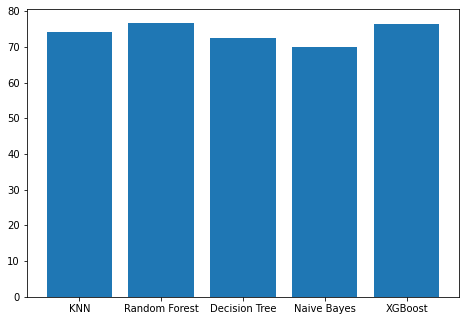

In [84]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(accuracy_dict.keys(), accuracy_dict.values())
plt.show()

In [87]:
from sklearn.ensemble import VotingClassifier

Ensemble = VotingClassifier(estimators=[('KNN', knn), ('RF', forest), ('DT', tree), ('NB', nb)],
                        voting='soft',
                        weights=[35, 45, 15, 5])

fit_Ensemble=Ensemble.fit(X_train,Y_train)
predictions = fit_Ensemble.predict(X_test)
test_score_Ensemble = round((100*fit_Ensemble.score(X_test,Y_test)),2)
test_score_Ensemble = round((100*fit_Ensemble.score(X_train,Y_train)),2)

Ensemble Model
Training Set Success Rate: 82.68%
Test Set Success Rate - Accuracy: 75.56%



           classical    hiphop      jazz    reggae      rock
precision   0.911493  0.676343  0.687173  0.516279  0.802312
recall      0.872314  0.760196  0.726141  0.327434  0.842233
f1          0.891473  0.715822  0.706120  0.400722  0.821788




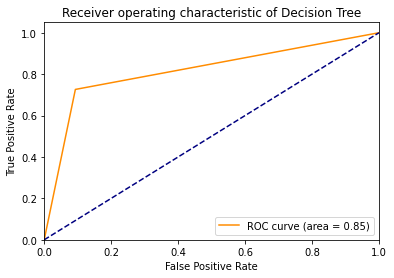

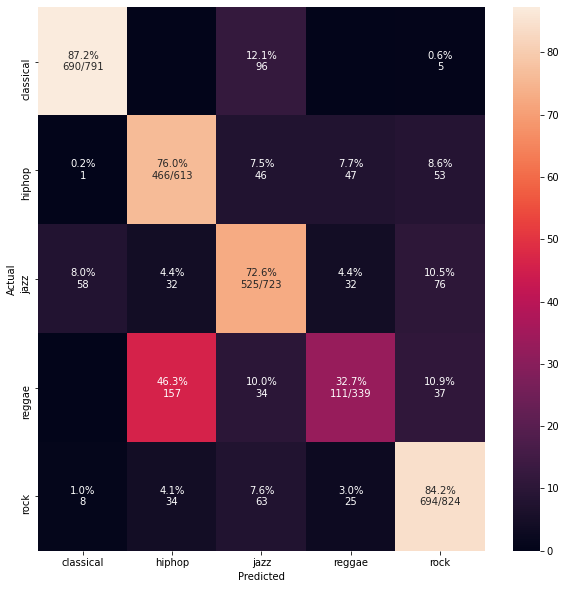

In [88]:
print_Stats(fit_Ensemble,X_train, Y_train,X_test, Y_test,"Ensemble Model", labels,predictions,accuracy_dict)

In [89]:
printCM(Y_test, predictions,labels)

TP cases for classical music is 690
TP cases for hiphop music is 466
TP cases for jazz music is 525
TP cases for reggae music is 111
TP cases for rock music is 694
------------------------------------
FP - Predicated classical instead of hiphop: 1 times
FP - Predicated classical instead of jazz: 58 times
FP - Predicated classical instead of reggae: 0 times
FP - Predicated classical instead of rock: 8 times
FP - Predicated hiphop instead of classical: 0 times
FP - Predicated hiphop instead of jazz: 32 times
FP - Predicated hiphop instead of reggae: 157 times
FP - Predicated hiphop instead of rock: 34 times
FP - Predicated jazz instead of classical: 96 times
FP - Predicated jazz instead of hiphop: 46 times
FP - Predicated jazz instead of reggae: 34 times
FP - Predicated jazz instead of rock: 63 times
FP - Predicated reggae instead of classical: 0 times
FP - Predicated reggae instead of hiphop: 47 times
FP - Predicated reggae instead of jazz: 32 times
FP - Predicated reggae instead of roc